In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import skew
from scipy.stats import norm, kurtosis
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy import optimize

from bootstrap import bootstrap
from tail_body_likelihood import tail_body_likelihood

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [2]:
#Downloading data and taking log of returns
data = pd.read_csv('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/c1/cryptocurrency_prices.txt', header = None).iloc[0]
data = data.str.split(pat = '\t').tolist()
data = [item for sublist in data for item in sublist]
log_data = np.log(list(map(lambda x, y: float(x) / float(y), data[1:], data[0:-2])))

In [7]:
#Compute first four moments
N = len(log_data) #number of log returns
mean = np.mean(log_data)
std = np.std(log_data)
skewness = skew(log_data)
exc_kurtosis = kurtosis(log_data, fisher = True)
print('Mean {:4.3f} \nStandard deviation {:4.2f} \nSkewness {:4.3f} \nExcess kurtosis {:4.3f}'.format(mean, std, skewness, exc_kurtosis))

Mean 0.004 
Standard deviation 0.04 
Skewness -0.279 
Excess kurtosis 5.331


(0.0001, 1)

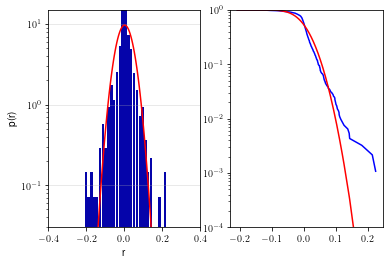

In [69]:
#Plot of empirical PDF vs Gaussian
x = np.linspace(min(log_data), max(log_data), 100)
g = 1/(std*np.sqrt(2*np.pi))*np.exp(-(x-mean)**2/(2*std**2)) #Gaussian PDF values computed on point grid 
n_bins = 30 #number of bins

#Plot of empirical CCDF vs Gaussian
data_sorted = sorted(log_data, reverse=False)
y = np.linspace(1, len(log_data), len(log_data)) #rank-frequency plot
y = 1 - y/(len(log_data)+1) #Calculating CCDF as rank-frequency plot
ccdf = [0.5*(1- math.erf((value-mean)/(std*math.sqrt(2)))) for value in data_sorted]

fig, ax = plt.subplots(1,2)
ax[0].hist(log_data, n_bins-1, log=True, density=True, rwidth =0.85, color='#0504aa')
ax[0].plot(x,g, color = 'red')
ax[0].set_xlim([-0.4, 0.4])
ax[0].set_ylim([0.03, 15])
ax[0].grid(axis='y', alpha=0.35)
ax[0].set_xlabel('r')
ax[0].set_ylabel('p(r)')
ax[1].semilogy(data_sorted, y, color = 'Blue')
ax[1].semilogy(data_sorted, ccdf, color = 'Red')
ax[1].set_ylim([1e-4, 1])

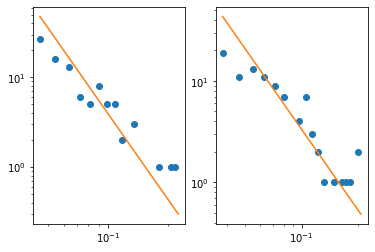

In [12]:
#Fitting right & left tails via Maximum Likelihood
p = 0.1 #defining tails as top (10 percent) of returns
#Right tail 
r_sorted = sorted(log_data, reverse=False)
r_right = r_sorted[round((1-p)*len(r_sorted)):]
n_rright = len(r_right) #number of returns selected as right tail
alpha_right = n_rright / sum(np.log(r_right/min(r_right)))

x_right = np.linspace(min(r_right), max(r_right),100) #grid of points between min and max value at right tail 
y_right = alpha_right*(x_right/min(r_right))**(-alpha_right-1)/min(r_right)
b_right, a_right = np.histogram(r_right, 20)

#Left tail
r_left = r_sorted[0:round((p)*len(r_sorted))]
r_left = [abs(value) for value in r_left]
n_rleft = len(r_left)
alpha_left = n_rleft / sum(np.log(r_left/min(r_left)))
x_left = np.linspace(min(r_left), max(r_left),100)
y_left = alpha_left*(x_left/min(r_left))**(-alpha_left-1)/min(r_left)
b_left, a_left = np.histogram(r_left, 20)

#Plotting
fig1, ax1 = plt.subplots(1, 2)
ax1[0].loglog(a_right[:-1], b_right, 'o')
ax1[0].loglog(x_right, y_right, subsx = 'auto')
#ax1[0].set_xscale('linear')

ax1[1].loglog(a_left[:-1], b_left, 'o')
ax1[1].loglog(x_left, y_left, subsx = 'auto')
#ax1[1].set_xscale('linear')

Right tail interval at 0.90 CL: [2.096, 2.508]
Left tail interval at 0.90 CL: [1.494, 1.741]


{'whiskers': [<matplotlib.lines.Line2D at 0x12535afa0>,
 'caps': [<matplotlib.lines.Line2D at 0x1253616a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12535ac40>,
 'medians': [<matplotlib.lines.Line2D at 0x125361d60>,
 'fliers': [<matplotlib.lines.Line2D at 0x125367100>,
 'means': []}

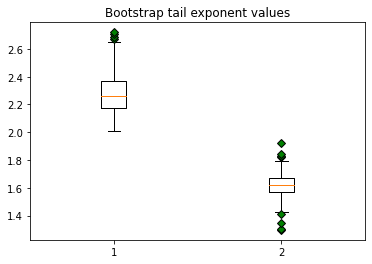

In [16]:
#Bootstrap analysis 
fraction = 0.8 #Fraction of data to be retained in each bootstrap sample
n_samples = 500 #number of bootstrap samples
ci_alpha = 0.9 #significance level
ci_right_samples = bootstrap(log_data, 'right', p)
ci_left_samples = bootstrap(log_data, 'left', p)
print('Right tail interval at {:4.2f} CL: [{:4.3f}, {:4.3f}]'.format(ci_alpha, ci_right_samples[round(0.5*(1-ci_alpha)*n_samples)], ci_right_samples[round(0.5*(1+ci_alpha)*n_samples)]))
print('Left tail interval at {:4.2f} CL: [{:4.3f}, {:4.3f}]'.format(ci_alpha, ci_left_samples[round(0.5*(1-ci_alpha)*n_samples)], ci_left_samples[round(0.5*(1+ci_alpha)*n_samples)]))

#Plotting the boxplots
green_diamond = dict(markerfacecolor='g', marker='D')
fig2, ax2 = plt.subplots()
ax2.set_title('Bootstrap tail exponent values')
ax2.boxplot([ci_right_samples, ci_left_samples], flierprops=green_diamond)


In [25]:
r = [abs(value) for value in log_data if value <0]

penalty = 10 
initial_params = [10,2,0.05]

args = [penalty, r]

par = optimize.fmin(tail_body_likelihood, args = (args[0], args[1]), x0=initial_params, xtol = 1e-12, maxiter = 1000, maxfun = 5000)

lambdaa, alpha, xmin = par
print('Parameters that maximizes likelihood: lambda = {:4.4f}, alpha = {:4.4f}, xmin = {:4.4f}'.format(lambdaa, alpha, xmin))

Optimization terminated successfully.
         Current function value: -946.690215
         Iterations: 208
         Function evaluations: 438
Parameters that maximizes likelihood: lambda = 119.4188, alpha = 0.3709, xmin = 0.0083


Text(0, 0.5, '\\textbf{$C(r)$}')

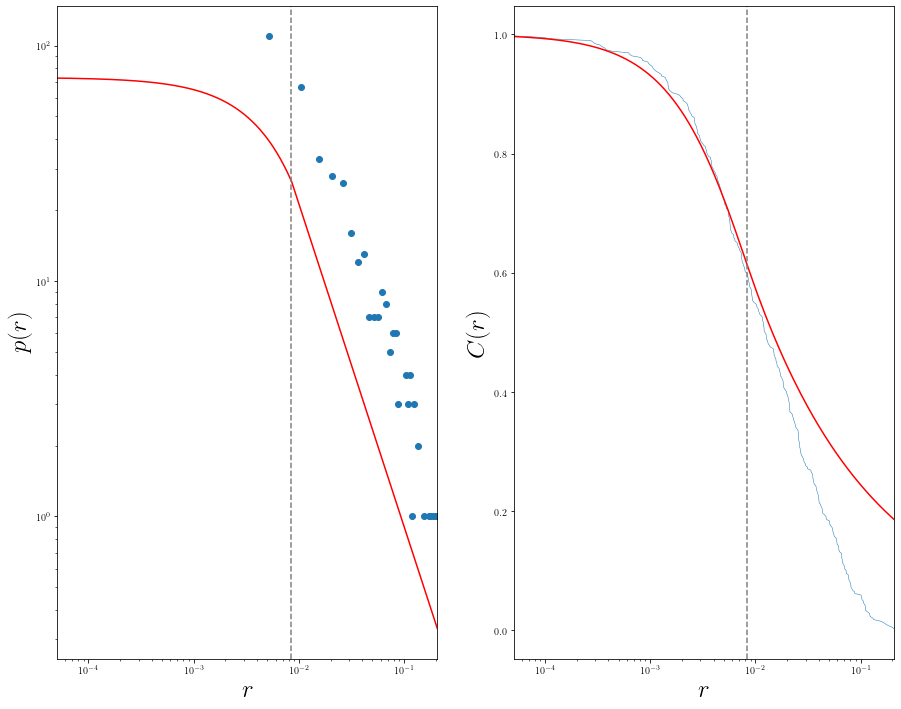

In [66]:
# Plotting empirical vs calibrated distribution 
C = 2 - np.exp(-lambdaa*xmin)
NB = 40 #number of bins 

r_sorted = sorted(r)
y = np.linspace(1, len(r_sorted), len(r_sorted)) #rank-frequency plot
y = 1 - y/(len(r_sorted)+1)

fig3, ax3 = plt.subplots(1,2)
fig3.set_figheight(12)
fig3.set_figwidth(15)
r_binedges, r_values = np.histogram(r, NB)
ax3[0].plot(r_values[1:], r_binedges, 'o')
x4 = np.linspace(0, xmin, 1000)
ax3[0].plot(x4, lambdaa*np.exp(-lambdaa*x4)/C, '-r')
x4 = np.linspace(xmin, max(r), 1000)
ax3[0].plot(x4, alpha*(x4/xmin)**(-alpha-1)/(C*xmin), '-r')
ax3[0].axvline(xmin, color='grey', linestyle = '--')
ax3[0].set_xlim([min(r), max(r)])
#ax3[0].set_ylim([0,0])
ax3[0].set_xscale('log')
ax3[0].set_yscale('log')
ax3[0].set_xlabel(r'\textbf{$r$}', fontsize = 25)
ax3[0].set_ylabel(r'\textbf{$p(r)$}', fontsize = 25)


ax3[1].plot(r_sorted,y, linewidth = 0.5)
x5 = np.linspace(min(r),xmin,1000);
ax3[1].plot(x5, 1-(1-np.exp(-lambdaa*x5))/C, '-r')
x6 = np.linspace(xmin, max(r_sorted)*10, 1000)
ax3[1].plot(x6,1-(1-np.exp(-lambdaa*xmin)+1-(xmin/x6)**alpha)/C, '-r' )
ax3[1].set_xlim([min(r_sorted), max(r_sorted)])
ax3[1].set_xscale('log')
ax3[1].axvline(xmin, color='grey', linestyle = '--')
ax3[1].set_xlabel(r'\textbf{$r$}', fontsize = 25)
ax3[1].set_ylabel(r'\textbf{$C(r)$}', fontsize = 25)